In [1]:
%matplotlib notebook
import matplotlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm

from matplotlib import colors

from fridge import Fridge
from tes import TES
from QET import QET
from detector import Detector
from electronics import Electronics
from absorber import Absorber
from simulated_noise import simulate_noise
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from MaterialProperties import TESMaterial

In [2]:
printing = False
fSnolab = Fridge("SNOLAB", 20e-3, 145e-3, 900e-3, 4.8, 0)
# Absorber: Silicon. Height 1mm. Radius 38.1mm. W safety 3mm. 
# Q: W safety removes a huge % of patterned surface area
absorber = Absorber("Si", "square", 1e-3, 10e-3, 3e-3, printing) # same as matlab
eSnolab = Electronics(fSnolab, fSnolab.get_TCP(), fSnolab.get_TMC())
eSLAC = Electronics(fSnolab, fSnolab.get_TMC(), fSnolab.get_TMC(), 5e-3, 6e-3, 25e-9, 25e-9, 4e-12)

tungsten = TESMaterial()

In [3]:
tes_w = 2.5e-6

h_fin = 900e-9 
ahole = 49e-12
sigma = tungsten._gPep_v

T_eq = -100

l_overlaps = []
l_fins = []
tes_lengths = []

l_over_min = 4e-6
l_over_delta = 1e-6
#l_over_delta = 4e-6 # testing

l_fin_min = 25e-6
l_fin_delta = 5e-6
#l_fin_delta = 15e-6 # testing

tes_min = 25e-6
tes_delta = 5e-6
#tes_delta = 10e-6 

while l_over_min < 35e-6:
    l_overlaps.append(l_over_min)
    l_over_min = l_over_min + l_over_delta
    
while l_fin_min < 300e-6:
    l_fins.append(l_fin_min)
    l_fin_min = l_fin_min + l_fin_delta 
    
while tes_min < 200e-6:
    tes_lengths.append(tes_min)
    tes_min = tes_min + tes_delta 

l_fins_mu = []
l_overlaps_mu = []
tes_lengths_mu = []

for l_o in l_overlaps:
    l_overlaps_mu.append(l_o*(10**6))
for l_f in l_fins:
    l_fins_mu.append(l_f*(10**6))
for t in tes_lengths:
    tes_lengths_mu.append(t*(10**6))
    
n_fins = [2, 4]

coverages = [0.001, 0.0025, 0.005, 0.01, 0.02, 0.03, 0.04]

In [4]:
optimum_detectors = []

for cov in coverages:
    print(cov*100, " % Coverage")
    for_cov = []
    for n_fin in n_fins:
        print("   -- ", n_fin, " Fins")
        min_resolution = 200
        optimum_detector = []

        for l_f in l_fins:
            #print("     -- ", l_f , " Length Fin ")
            for tes_l in tes_lengths:
                for l_over in l_overlaps:
                    perim = tes_l*2 + 14e-6*2 - 6e-6*n_fin
                    overlap_p = n_fin*l_over*2
                    if overlap_p > perim: 
                        continue
            
                    # Calculate QET Active Area
                    wempty = 6e-6
                    wempty_tes = 7.5e-6
                    nhole = 3*n_fin 
                    afin_empty = n_fin * l_f * wempty + 2 * tes_l * wempty_tes + nhole * ahole                          
                    a_fin = np.pi*l_f*(l_f + (tes_l/2)) - afin_empty   
            
                    N_tes = cov*absorber._SA/a_fin
                    N_tes = int(N_tes)
                    
                    if N_tes == 0: N_tes =1 
         
            
                    res_n = tungsten._rho_electrical*tes_l/(tes_w*(40e-9)*N_tes)
            
                    tes = TES(tes_l, tes_w, l_over, n_fin, sigma, T_eq, res_n, 0.45, tungsten, printing)
                    qet = QET( l_f, h_fin, tes, ahole)
                
                    det = Detector("det name", fSnolab, eSLAC, absorber, qet, tes, 1, 0)
                    e_res = simulate_noise(det)
            
                    if e_res < min_resolution: 
                        min_resolution = e_res
                        tes_opt = tes
                        qet_opt = qet
                        det_opt = det 
        
        optimum_detector.append(tes_opt)
        optimum_detector.append(qet_opt)
        optimum_detector.append(det_opt)
        
        for_cov.append(optimum_detector)
        
        
        #print("      -- Optumum Detector ", optimum_detector)
        #print("      -- Both N Fins      ", for_cov)
        
        print("      -- BASELINE RESOLUTION: ", min_resolution) 

        pActiveArea = det_opt._SA_active/det_opt._absorber.get_SA()
        pPassiveArea = det_opt._SA_passive/det_opt._absorber.get_SA()

        print("      -- TES Length             ", tes_opt._l)
        print("      -- Fin Length             ", qet_opt._l_fin)
        print("      -- Overlap                ", qet_opt.l_overlap)
        print("      -- N Fins                 ", tes_opt._n_fin)
        print("      -- Percent Active SA      ", pActiveArea)
        print("      -- Percent Passive SA     ", pPassiveArea)
        print("      -- Percent QP Absorb SA   ", det_opt._fSA_qpabsorb)
        print("      -- N tes                  ", det_opt._tes._nTES)
        print("      -- Rn                     ", det_opt._tes._total_res_n )
        print("      -- fQP Absorb             ", det_opt._qet._eQPabsb)
        print("      -- Phonon Absorption Time ", det_opt._t_pabsb)
        print("      -- Time ETF               ", det_opt._tes._tau_etf)
        print("      -- Cells Fit              ", det_opt._cells_fit)
    
    optimum_detectors.append(for_cov)

0.1  % Coverage
   --  2  Fins
     --  2.5e-05  Length Fin 
     --  4e-05  Length Fin 
     --  5.5e-05  Length Fin 
     --  7.000000000000001e-05  Length Fin 
     --  8.5e-05  Length Fin 
     --  0.0001  Length Fin 
     --  0.000115  Length Fin 
     --  0.00013000000000000002  Length Fin 
     --  0.00014500000000000003  Length Fin 
     --  0.00016000000000000004  Length Fin 
     --  0.00017500000000000005  Length Fin 
     --  0.00019000000000000006  Length Fin 
     --  0.00020500000000000008  Length Fin 
     --  0.0002200000000000001  Length Fin 
     --  0.0002350000000000001  Length Fin 
     --  0.0002500000000000001  Length Fin 
     --  0.0002650000000000001  Length Fin 
     --  0.0002800000000000001  Length Fin 
     --  0.00029500000000000007  Length Fin 
      -- Optumum Detector  [<tes.TES object at 0x7f3232385650>, <QET.QET object at 0x7f3231d0bf50>, <detector.Detector object at 0x7f3231d0bf10>]
      -- Both N Fins       [[<tes.TES object at 0x7f3232385650>, <

     --  4e-05  Length Fin 
     --  5.5e-05  Length Fin 
     --  7.000000000000001e-05  Length Fin 
     --  8.5e-05  Length Fin 
     --  0.0001  Length Fin 
     --  0.000115  Length Fin 
     --  0.00013000000000000002  Length Fin 
     --  0.00014500000000000003  Length Fin 
     --  0.00016000000000000004  Length Fin 
     --  0.00017500000000000005  Length Fin 
     --  0.00019000000000000006  Length Fin 
     --  0.00020500000000000008  Length Fin 
     --  0.0002200000000000001  Length Fin 
     --  0.0002350000000000001  Length Fin 
     --  0.0002500000000000001  Length Fin 
     --  0.0002650000000000001  Length Fin 
     --  0.0002800000000000001  Length Fin 
     --  0.00029500000000000007  Length Fin 
      -- Optumum Detector  [<tes.TES object at 0x7f3231d1b2d0>, <QET.QET object at 0x7f3231d1bb50>, <detector.Detector object at 0x7f3231d1bc90>]
      -- Both N Fins       [[<tes.TES object at 0x7f3231d1bb10>, <QET.QET object at 0x7f3231d1bed0>, <detector.Detector object 

/home/summer/DarkOpt/simulated_noise.py:129: RuntimeWarning: overflow encountered in multiply
  dIdV_step = dIdV0 * (1 - (taup_p - tau_I) / (taup_p - taup_m) * np.exp(-t / taup_p) - (taup_m - tau_I) / (taup_m - taup_p) * np.exp(-t / taup_m))


     --  4e-05  Length Fin 
     --  5.5e-05  Length Fin 
     --  7.000000000000001e-05  Length Fin 
     --  8.5e-05  Length Fin 
     --  0.0001  Length Fin 
     --  0.000115  Length Fin 
     --  0.00013000000000000002  Length Fin 
     --  0.00014500000000000003  Length Fin 
     --  0.00016000000000000004  Length Fin 
     --  0.00017500000000000005  Length Fin 
     --  0.00019000000000000006  Length Fin 
     --  0.00020500000000000008  Length Fin 
     --  0.0002200000000000001  Length Fin 
     --  0.0002350000000000001  Length Fin 
     --  0.0002500000000000001  Length Fin 
     --  0.0002650000000000001  Length Fin 
     --  0.0002800000000000001  Length Fin 
     --  0.00029500000000000007  Length Fin 
      -- Optumum Detector  [<tes.TES object at 0x7f3231d1b190>, <QET.QET object at 0x7f3231d1b290>, <detector.Detector object at 0x7f3231d1b6d0>]
      -- Both N Fins       [[<tes.TES object at 0x7f3231d1b190>, <QET.QET object at 0x7f3231d1b290>, <detector.Detector object 

     --  4e-05  Length Fin 
     --  5.5e-05  Length Fin 
     --  7.000000000000001e-05  Length Fin 
     --  8.5e-05  Length Fin 
     --  0.0001  Length Fin 
     --  0.000115  Length Fin 
     --  0.00013000000000000002  Length Fin 
     --  0.00014500000000000003  Length Fin 
     --  0.00016000000000000004  Length Fin 
     --  0.00017500000000000005  Length Fin 
     --  0.00019000000000000006  Length Fin 
     --  0.00020500000000000008  Length Fin 
     --  0.0002200000000000001  Length Fin 
     --  0.0002350000000000001  Length Fin 
     --  0.0002500000000000001  Length Fin 
     --  0.0002650000000000001  Length Fin 
     --  0.0002800000000000001  Length Fin 
     --  0.00029500000000000007  Length Fin 
      -- Optumum Detector  [<tes.TES object at 0x7f3231d0bf90>, <QET.QET object at 0x7f3231d12410>, <detector.Detector object at 0x7f3231d12990>]
      -- Both N Fins       [[<tes.TES object at 0x7f3231d120d0>, <QET.QET object at 0x7f3231d12ad0>, <detector.Detector object 

In [20]:
passive = [[],[]]
active = [[],[]]
passive_tot = [[],[]]

overlap_area = [[],[]]
overlap_area_tes_l = [[],[]]

e_resolution = [[],[]]

qp_eff = [[],[]]

for c in optimum_detectors:
    for n in range(len(c)):
        tes = c[n][0]
        qet = c[n][1]
        det = c[n][2]
        
        passive[n].append(det._SA_passive/det._absorber._SA)
        active[n].append(det._SA_active/det._absorber._SA)
        passive_tot[n].append(det._SA_passive/(det._SA_passive+det._SA_active))
        
        qp_eff[n].append(qet._eQPabsb)
        overlap_area[n].append(tes._A_overlap)
        overlap_area_tes_l[n].append(tes._A_overlap/tes._l)
        
        e_resolution[n].append(simulate_noise(det))
   

<IPython.core.display.Javascript object>


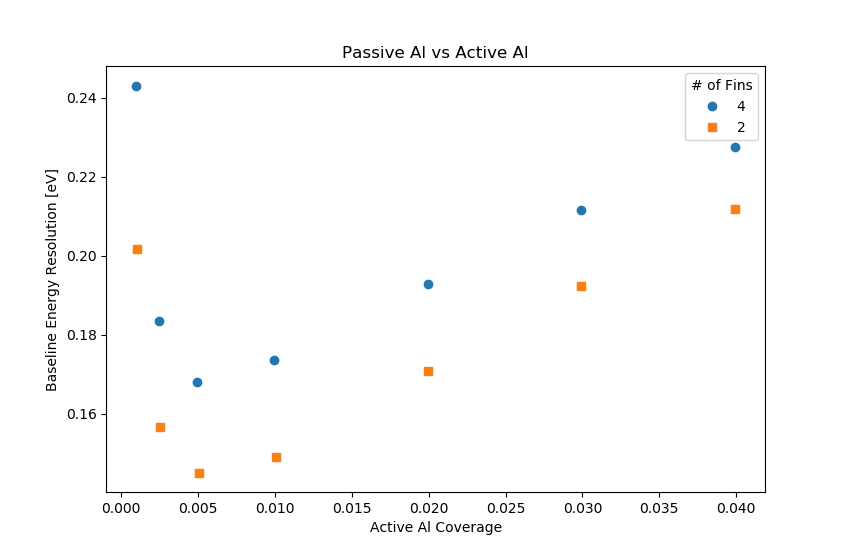

In [24]:
f, ax = plt.subplots(1)


ax.plot(active[1], e_resolution[1], "o", label = "4" )
ax.plot(active[0], e_resolution[0], "s", label = "2" )

plt.legend(title = "# of Fins")
ax.set_title("Passive Al vs Active Al")
ax.set_xlabel("Active Al Coverage")
ax.set_ylabel("Baseline Energy Resolution [eV]")
plt.show()

<IPython.core.display.Javascript object>


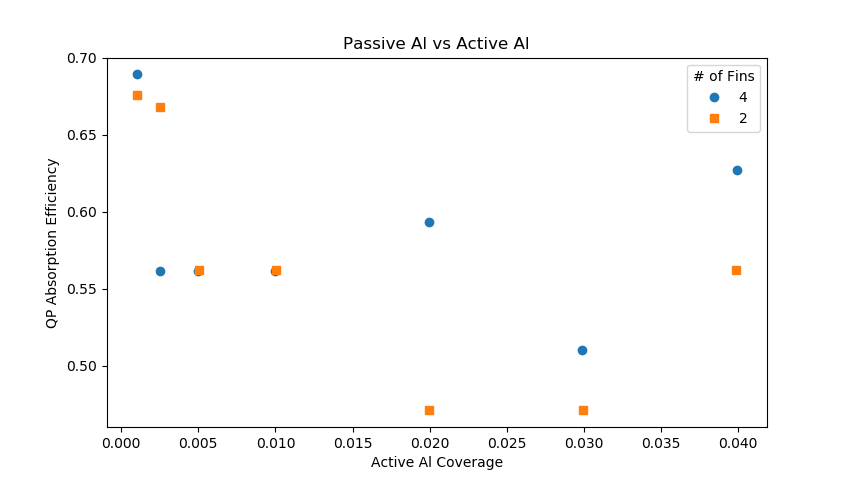

In [25]:
# Why is 2 fin design always Better?

f, ax = plt.subplots(1)


ax.plot(active[1], qp_eff[1], "o", label = "4" )
ax.plot(active[0], qp_eff[0], "s", label = "2" )

plt.legend(title = "# of Fins")
ax.set_title("Passive Al vs Active Al")
ax.set_xlabel("Active Al Coverage")
ax.set_ylabel("QP Absorption Efficiency")
plt.show()

<IPython.core.display.Javascript object>


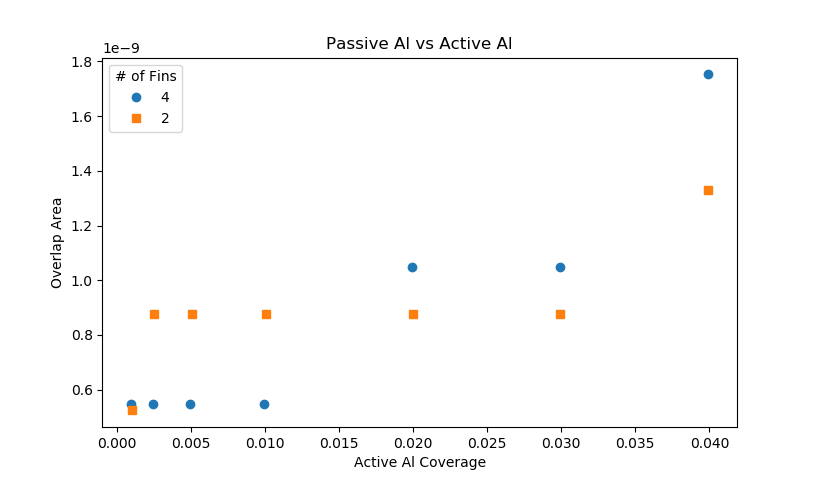

In [23]:
f, ax = plt.subplots(1)


ax.plot(active[1], overlap_area[1], "o", label = "4" )
ax.plot(active[0], overlap_area[0], "s", label = "2" )

plt.legend(title = "# of Fins")
ax.set_title("Passive Al vs Active Al")
ax.set_xlabel("Active Al Coverage")
ax.set_ylabel("Overlap Area")
plt.show()

<IPython.core.display.Javascript object>


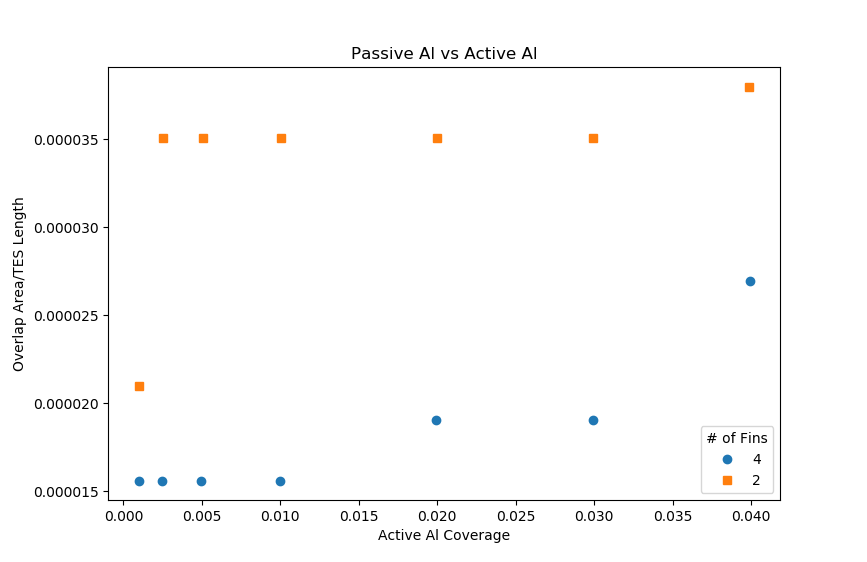

In [22]:
f, ax = plt.subplots(1)


ax.plot(active[1], overlap_area_tes_l[1], "o", label = "4" )
ax.plot(active[0], overlap_area_tes_l[0], "s", label = "2" )

plt.legend(title = "# of Fins")
ax.set_title("Passive Al vs Active Al")
ax.set_xlabel("Active Al Coverage")
ax.set_ylabel("Overlap Area/TES Length")
plt.show()

In [ ]:
f, ax = plt.subplots(1)


ax.plot(active[1], passive[1], "o", label = "4" )
ax.plot(active[0], passive[0], "s", label = "2" )

plt.legend(title = "# of Fins")
ax.set_title("Passive Al vs Active Al")
ax.set_xlabel("Active Al Coverage")
ax.set_ylabel("Passive Al Coverage")
plt.show()

<IPython.core.display.Javascript object>


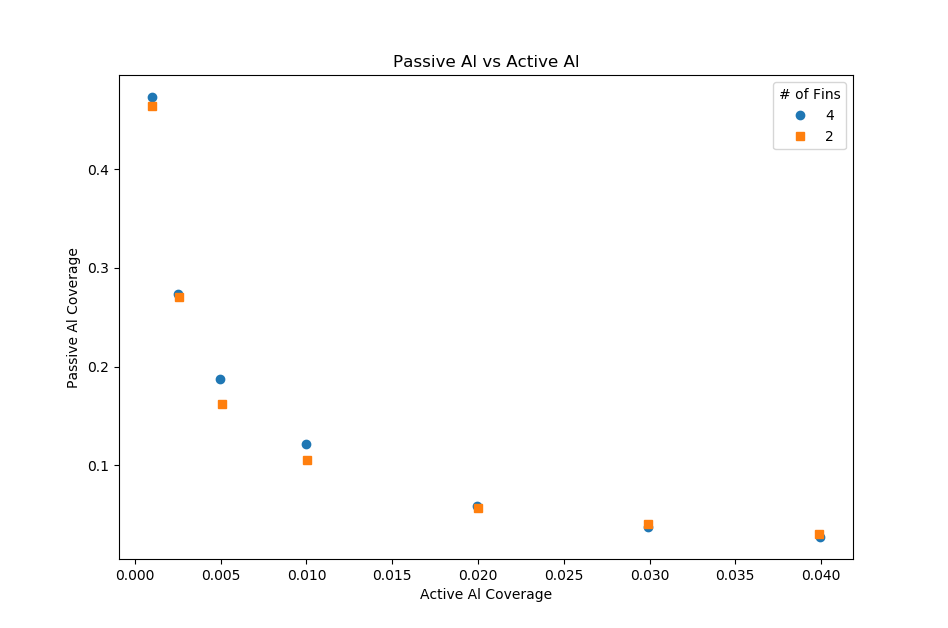

In [12]:
f, ax = plt.subplots(1)


ax.plot(active[1], passive_tot[1], "o", label = "4" )
ax.plot(active[0], passive_tot[0], "s", label = "2" )

plt.legend(title = "# of Fins")
ax.set_title("Passive Al vs Active Al")
ax.set_xlabel("Active Al Coverage")
ax.set_ylabel("Passive Al Coverage")
plt.show()